#### Q. 1. Build a ANN model from scratch for predicting best housing selling prices in Boston using three features (i.e. “RM: average number of rooms per dwelling; LSTAT: percentage of population considered lower status: PTRATIO: pupil-teacher ratio by town”) of Boston dataset (Use Sklearn Dataset) by using Stochastic Gradient Descent algorithm for the loss functions: 
- (a) Mean Square Error 
- (b) Huber Loss 
- (c) Squared Epsilon Hinge Loss 
- (i) Plot comparative loss curve for at least 500 epochs.
- (ii) Print comparison of Boston housing selling prices among above mentioned loss functions using bar chart plot and which loss function is providing better housing selling prices among others.
- (iii) Implement above ANN model with Keras Library and verify the above results.

#### Q. 2. Build a ANN model from to recognize breast cancer from Breast Dataset (Use Sklearn Dataset). Use Stochastic gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the parameters of the ANN model for loss functions 
- (a) Binary cross entropy 
- (b) Dice Loss 
- (i) Plot comparative loss curve for at least 200 epochs.
- (ii) Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy and ROUC curve for each loss function.
- (iii) Repeat part (ii) to (iii) using Adam gradient descent algorithm
- (iv) Implement above ANN model with Keras Library and verify the above results. 

#### Q.3. Build a ANN model from scratch to recognize diabetes-from pima-indians-diabetes-database (i.e. https://github.com/duonghuuphuc/keras/tree/master/dataset ). Use Stochastic gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the ANN model for loss functions 
- (a) Binary cross entropy 
- (b) Dice Loss 
- (i) Visualize input dataset and Plot comparative loss curve for at least 200 epochs.
- (ii) Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy and ROUC curve for each loss function.
- (iii) Repeat part (i) to (ii) using Adam gradient descent algorithm
- (iv) Implement above ANN model with Keras Library and verify the above results. 

#### Q. 4. Build a ANN model from scratch to recognize Iris-setosa, Iris -virginica and Iris-versicolor from the Iris Dataset ((Use Sklearn Dataset) which contains four features (length and width of sepals and petals) of 50 samples of three species of Iris (Iris setosa, Iris virginica and Iris versicolor. For implementation, use Stochastic gradient descent algorithm to learn model with parameters for α = 0.01and random parameters of the ANN model for the Softmax loss function 
- (i)Visualize data by boxplot of Sepal Length & Sepal width and Petal Length and width for three IRIS
species. 
- (ii) Plot comparative loss curve for at least 200 epochs.
- (iii) Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy and ROUC curve
- (iv) Visualize classified data by Scatter plot
- (v) Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy and ROUC curve for each loss function.
- (vi) Repeat part (ii) to (v) using Adam gradient descent algorithm
- (vii) Implement above ANN model with Keras Library and verify the above results. 

In [ ]:
dataframe = pandas.read_csv("iris.csv", header=None)
dataset = dataframe.values
X = dataset[:,0:4].astype(float)
Y = dataset[:,4]

#### Q. 5. Build a ANN model from scratch to recognize human emotion using Facial emotion recognition dataset (FER2013) (https://github.com/gitshanks/fer2013). For implementation, use Stochastic gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the ANN model for the Softmax loss function 
- (i)Visualize Facial emotion recognition dataset (FER2013. 
- (ii) Plot comparative loss curve for at least 200 epochs.
- (iii)Print confusion matrix, calculate classification metrics such as precision, recall, f1-score and accuracy and ROUC curve
- (iv) Repeat part (ii) to (iii) using Adam gradient descent algorithm
- (v) Implement above ANN model with Keras Library and verify the above result

In [1]:
#Importing required Libraries

import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import pandas as pd

In [11]:
#Defining required Functions

def softmax(Input, Derivative = False , dE = None):
    
    if(Derivative):
        Soft = np.array([softmax(Input)])
        der = Soft*(np.identity(len(Input)) - np.transpose(Soft))
        output = np.matmul(np.array([dE]),der)[0]
        return output
    else:
        Input = np.array(Input)
        Numerator = np.exp(Input)
        output = Numerator/sum(Numerator)
        return (output)

def sigmoid_activation(Input, Derivative = False , dE = None):
    if(Derivative):
        S = sigmoid_activation(Input)
        out = S*(1-S) * dE
        return(out)
    else:
        if(Input<-50): Input = -50
        output = 1/(np.exp(-1 * Input)+1)
        return(output)

def neuron_forward(X,Params):
    W,B = Params
    out = np.dot(X,W) + B
    activated = sigmoid_activation(out)
    
    if(np.isnan(activated).any()):
        print("Debug logs:")
        print("X:",X)
        print("W:",W)
        print("B:",B)
        print("Out:",out)
        print("Activated:",activated)
        raise Exception("Nan detected!")
        
    return activated

def neuron_backward(dE,X,Params):
    W,B = Params
    dE = sigmoid_activation(np.dot(X,W) + B,Derivative = True,dE = dE)
    dW = np.array(dE)*X
    dB = dE
    W = W - dW
    B = B - dB
    dX = np.array(dE)*W
    return (W,B),(dX)

def add_dense_layer(N_Neurons, Model = [], input_size = None ):
    
    if(input_size==None):
        input_size = len(Model[-1])
        
    new_layer = []
    for i in range(N_Neurons):
        new_layer = new_layer + [(np.random.rand(input_size),np.random.rand())]
    Model = Model + [new_layer]
    
    return Model

def Forward_propogation(Model , X ,Activation = None):
    All_outputs = [X]
    for layer in Model:
        Layer_output = []
        for neuron in layer:
            Layer_output = Layer_output + [neuron_forward(All_outputs[-1],neuron)]
        All_outputs = All_outputs + [Layer_output]
        
    if(Activation != None):
        All_outputs = All_outputs + [Activation(All_outputs[-1])]
    else:
        All_outputs = All_outputs + [All_outputs[-1]]
        
    return All_outputs
        
def Back_propogation(Model,Outputs,Error,Activation = None):
    if(Activation != None):
        Error = Activation(Outputs[-1], Derivative = True , dE = Error)
        
    n_layers = len(Model)
    Input_errors = np.array(Error)
    
    for i in range(n_layers):
        Out_Error = 0

        for j in range(len(Model[n_layers - i -1])):
            Model[n_layers - i -1][j] , dX = neuron_backward(Input_errors[j],Outputs[n_layers - i -1],Model[n_layers - i -1][j])
            Out_Error = Out_Error + dX
        Input_errors = Out_Error.copy()
        
    return Model

def display_weights(Model):
    print("\n**************** Model Structure ******************")
    for i,layer in enumerate(Model):
        print("\n--------Layer {}---------".format(i+1))
        for node in layer:
            print(node)
    print("*********************************************\n")
    
def Accuracy(A,B):
    out = np.mean(A == B)
    return out

In [12]:
#Reading and viewing data

path = "challenges-in-representation-learning-facial-expression-recognition-challenge/"
data = pd.read_csv(path+'icml_face_data.csv')

print("Number of emotions: ",data['emotion'].unique())
data.head()

Number of emotions:  [0 2 4 6 3 5 1]


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [13]:
#Function to prepare data
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

#Prepare data
X_train,Y_train = prepare_data(data)

print(np.shape(X_train),np.shape(Y_train))

(35887, 48, 48) (35887,)


<Figure size 432x288 with 0 Axes>

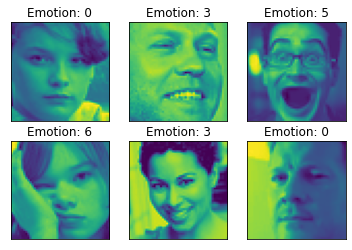

In [22]:
#Visualize Facial emotion recognition dataset

plt.figure()
fig, ax = plt.subplots()

for i in range(6):
    plt.subplot(2,3,i+1)
    t= np.random.randint(35886)
    plt.title("Emotion: {}".format(Y_train[t]))
    plt.imshow(X_train[t])

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

In [23]:
#Defining the model

Model = add_dense_layer(10,input_size =48*48)
Model = add_dense_layer(10,Model)
Model = add_dense_layer(7,Model)

#display_weights(Model)

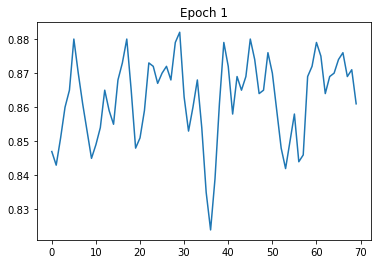

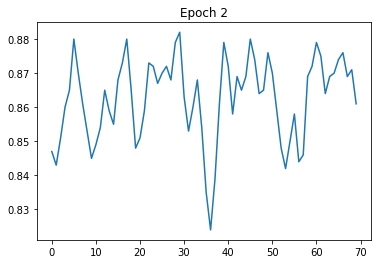


Loss over Epochs: [0.8619834480452532, 0.8619834480452532]


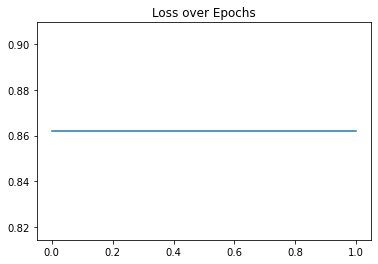

In [24]:
#Perform Training and plotting comparative loss curve

n_classes = 7
learning_rate = 0.01
Epochs = 2

Loss = []
for i in tqdm.tqdm(range(Epochs),position   = 0,leave = True,desc = "Epochs"):
    
    record = []
    for X,Truth in tqdm.tqdm(zip(X_train,Y_train),position   = 1,leave = False,total = len(Y_train), desc = "Input Images"):
        
        X = X.flatten()/255
        
        #Obtain Predictions
        Outputs = Forward_propogation(Model,X,softmax)

        #Save prediction for plotting
        record = record + [np.argmax(Outputs[-1])]
        
        #Calculate error
        temp = [0]*n_classes
        temp[Truth] = 1
        Error = (Outputs[-1] - temp)* learning_rate
        
        #Backpropogate using error
        Model = Back_propogation(Model,Outputs,Error,softmax)
    
    plt.figure()
    Accuracy  = (record != Y_train)
    plt.plot([np.mean(Accuracy[i:i+1000]) for i in range(0,len(Accuracy)-1000,500)])
    plt.title("Epoch {}".format(i+1))
    plt.show()
    
    Loss = Loss + [np.mean(record != Y_train)]

plt.figure()
plt.plot(Loss)
plt.title("Loss over Epochs")
plt.show

print("Loss over Epochs:",Loss)


In [25]:
#Display confusion Matrix

y_actu = pd.Series(Y_train, name='Actual')
y_pred = pd.Series(record, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,0
Actual,
0,4953
1,547
2,5121
3,8989
4,6077
5,4002
6,6198


In [29]:
print("Accuracy is: ",Accuracy(y_actu,y_pred))
print("Precision, recall and f1-score cannot be calculated since this is not binary classification")

Accuracy is:  0.13801655195474685
Precision, recall and f1-score cannot be calculated since this is not binary classification


In [50]:
import tensorflow.keras as keras
from sklearn.preprocessing import LabelEncoder

In [51]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(10, input_dim=48*48, activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='sigmoid'))
model.add(keras.layers.Dense(7, activation='sigmoid'))
model.add(keras.layers.Dense(7, activation='softmax'))

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
# encode class values as integers

Y_train_encoded = keras.utils.to_categorical(Y_train)

model.fit(x= X_train.reshape(len(X_train),48*48),y= Y_train_encoded, batch_size=1, epochs=2, verbose=1)

Epoch 1/2
35887/35887 [==============================] - 61s 2ms/step - loss: 1.8142 - accuracy: 0.2495
Epoch 2/2
35887/35887 [==============================] - 60s 2ms/step - loss: 1.8130 - accuracy: 0.2505
